# Check kinesin series MBAR outputs

In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import csv
import numpy as np
from math import sqrt

from rdkit.Chem.Draw import IPythonConsole
# IPythonConsole.ipython_useSVG=True
from IPython.display import display
from PIL import Image

import matplotlib.image as mpimg 
import seaborn as sns
from matplotlib import colors

In [2]:
def plotGradients(pert_name, axis, perts_path, title, yax=True):
    """Plot dG gradient plot in KbT and compute forward VS backward RMSE per timepoint pair"""
    
    def read_gradients(pert, perts_path):
        """Reads gradient output by Sire, returns as pd dataframe"""
        
        gradient_files = glob.glob(perts_path+"/"+pert+"/free/lambda*/gradients.dat")
        
        # loop over each lambda window for this pert:
        rep_dict = {}
        for gradient_file in gradient_files:
            
            # read in gradients:
            gradients_df = pd.read_csv(gradient_file, sep="\t")
            lambda_val = gradients_df.columns.values[0].split(" ")[2]

            gradient_vals = []
            for val in gradients_df.values:
                gradient_vals.append(float(val[0].split(" ")[-1]))
            
            # grab mean + std over all gradients:
            mean_gradient = np.mean(gradient_vals)
            std_gradient = np.std(gradient_vals)
            
            rep_dict[str(lambda_val)] = [mean_gradient, std_gradient]
        
        # make dict into df for easier plotting:
        gradients_processed_df = pd.DataFrame.from_dict(rep_dict, orient="index", columns=["mean", "std"])

        return gradients_processed_df.sort_index()
    
    
   
    fwd_gradients = read_gradients(pert_name.split("~")[0]+"~"+pert_name.split("~")[1], perts_path)
    bck_gradients = read_gradients(pert_name.split("~")[1]+"~"+pert_name.split("~")[0], perts_path)

    bck_gradients_reversed = bck_gradients.iloc[::-1]*-1
    
    # compute RMSE between forward and backward gradients:
    squared_errors = []
    for fwd, bck in zip(fwd_gradients["mean"].values, bck_gradients_reversed["mean"].values):
        squared_errors.append((fwd-bck)**2)
    mean_squared_error = np.mean(squared_errors)
    rmse = round(sqrt(mean_squared_error), 1)
    rmse_string = "RMSE:\n"+str(rmse)

    # now plot with formatting:
    axis.errorbar(fwd_gradients.index, fwd_gradients["mean"], yerr=fwd_gradients["std"], marker="o", label="Forward")
    axis.errorbar(fwd_gradients.index, bck_gradients_reversed["mean"], yerr=bck_gradients_reversed["std"], marker="o", label="Back")
    axis.annotate(rmse_string, xy=(0.1, 0.8), xycoords="axes fraction", size=11)
    
    axis.set_xticklabels(range(len(fwd_gradients["mean"])))
    if not yax:
        axis.get_yaxis().set_visible(False)
    elif yax:
        axis.yaxis.set_label_coords(-0.4,0.7)
        
    axis.set_xlabel("Lambda window")
    axis.set_ylabel("$\Delta$G gradient / $K_{B}T$")
    axis.set_title(title)
  

In [3]:
def plotOverlapMatrix(info, ax, title, colourbar=False):
    ovlp_mtx = np.matrix(info)
    ovlp_mtx = np.reshape(ovlp_mtx, (-1, num_lambdas))


    cmap = colors.ListedColormap(['#FBE8EB','#88CCEE','#78C592', '#117733'])
    bounds=[0.0, 0.025, 0.1, 0.3,0.8]
    norm = colors.BoundaryNorm(bounds, cmap.N, clip=False)
    cbar_kws=dict(ticks=[.025, .1, .3,0.8])
    if colourbar:
        ax = sns.heatmap(ovlp_mtx,annot=False, fmt='.2f', linewidths=.3, 
                    annot_kws={"size": 12},square=False,robust=True,cmap=cmap, 
                    norm=norm,cbar_kws=cbar_kws, ax=ax)
    elif not colourbar:
        ax = sns.heatmap(ovlp_mtx,annot=False, fmt='.2f', linewidths=.3,cmap=cmap, 
                    annot_kws={"size": 12},square=False,robust=True, 
                    norm=norm, ax=ax, cbar=False)
    ax.set_title(title)
    ax.xaxis.tick_top()

In [69]:
# read in dict with mbar outputs:
mbar_dict = {}
with open("../yOUTPUTs/mbar_outputs_17w_ctl.csv", "r") as readfile:
    reader = csv.reader(readfile)
    for row in reader:
        mbar_dict[row[0]] = row[1:]

# read in second results:
with open("../yOUTPUTs/mbar_outputs_17w_tip8.csv", "r") as readfile:
    reader = csv.reader(readfile)
    for row in reader:
        mbar_dict[row[0]] += row[1:]


Perturbations; black=control, blue=split8


/Users/jscheen/anaconda2/envs/cresset/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


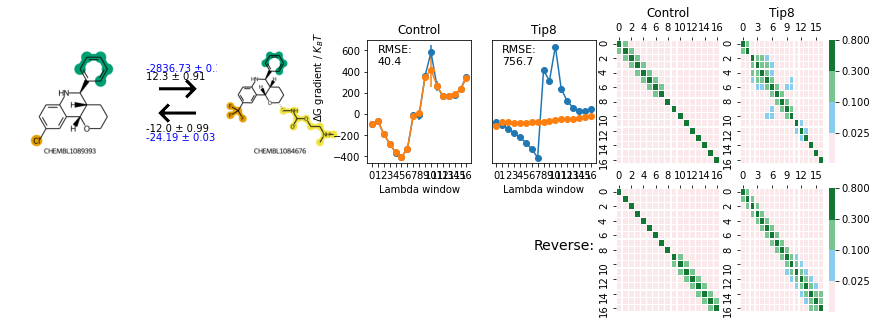

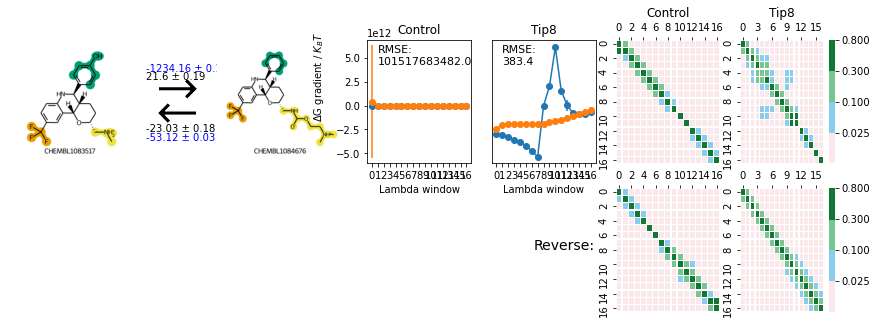

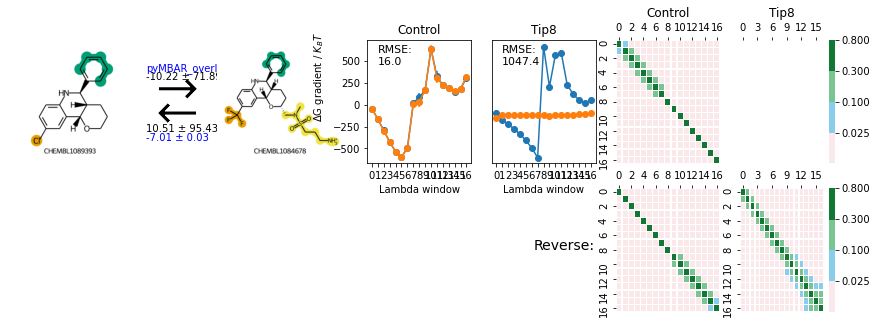

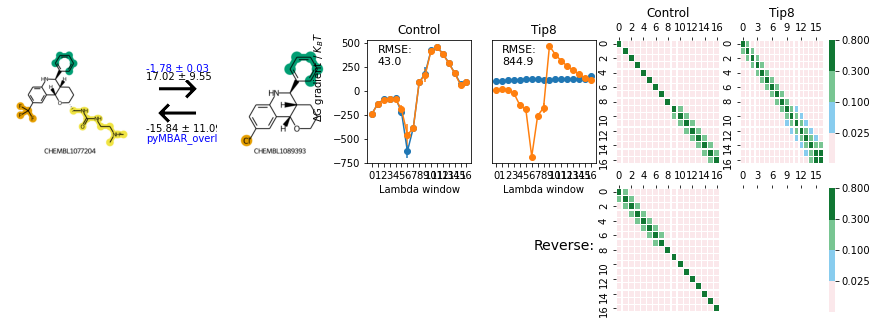

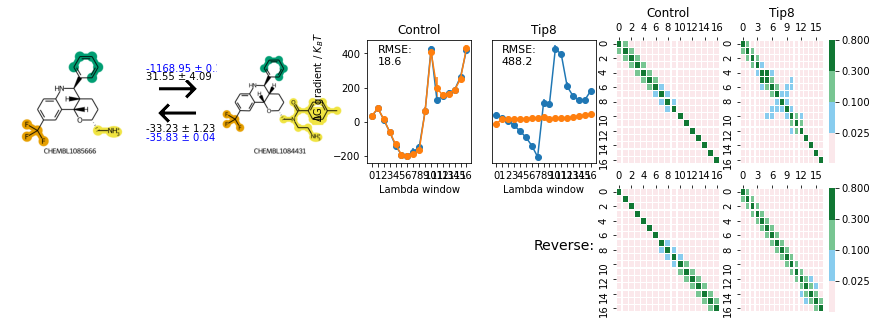

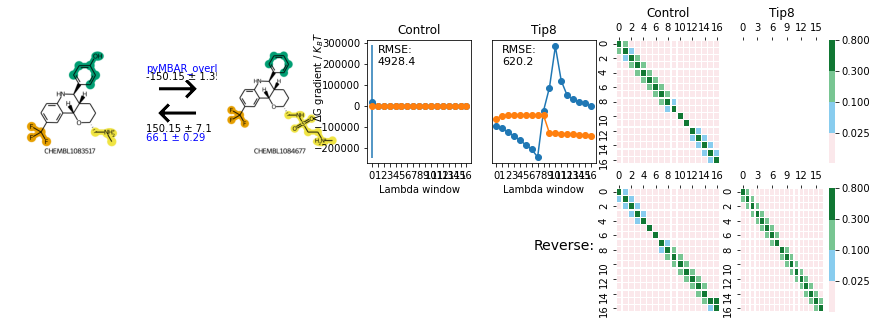

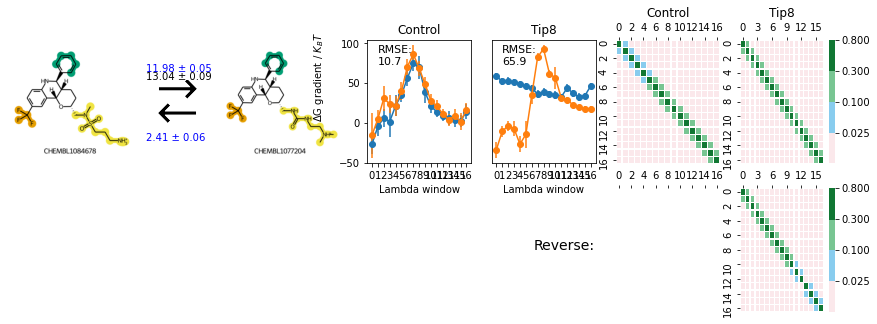

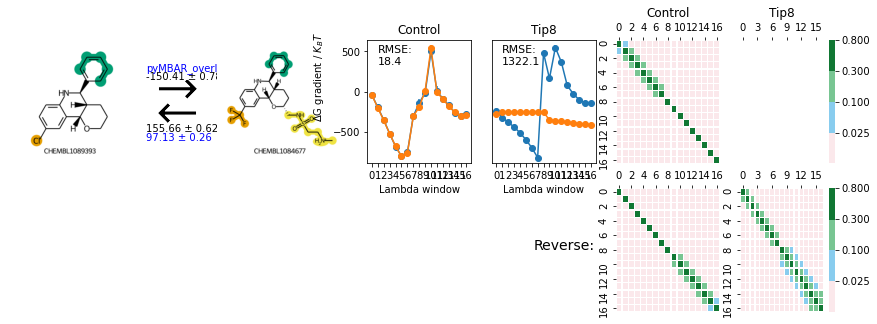

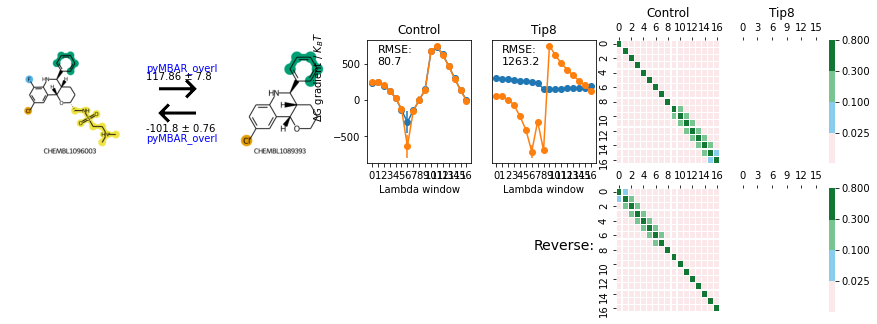

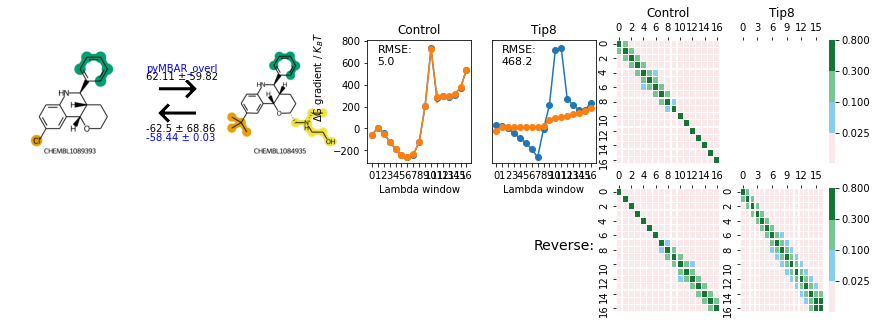

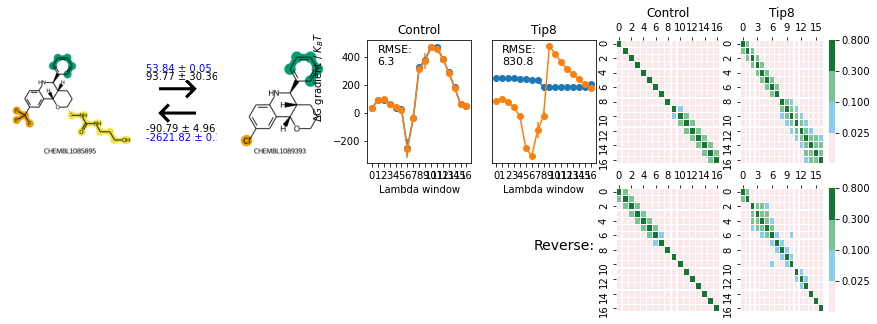

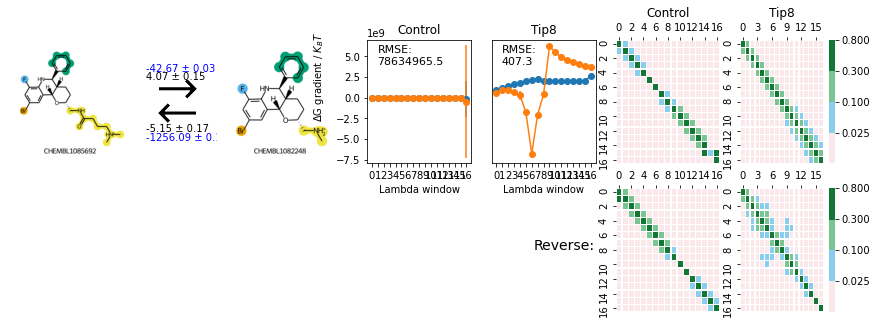

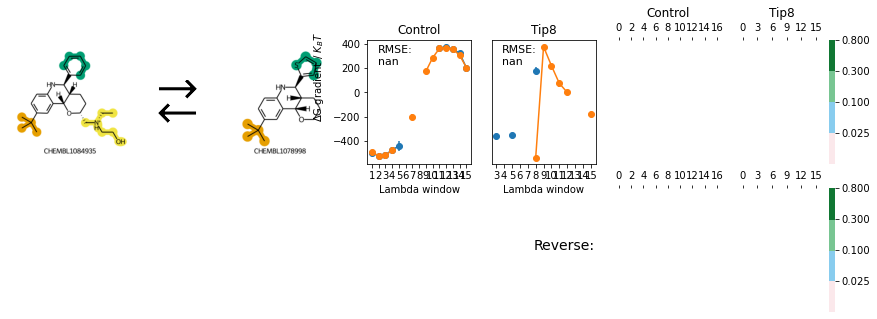

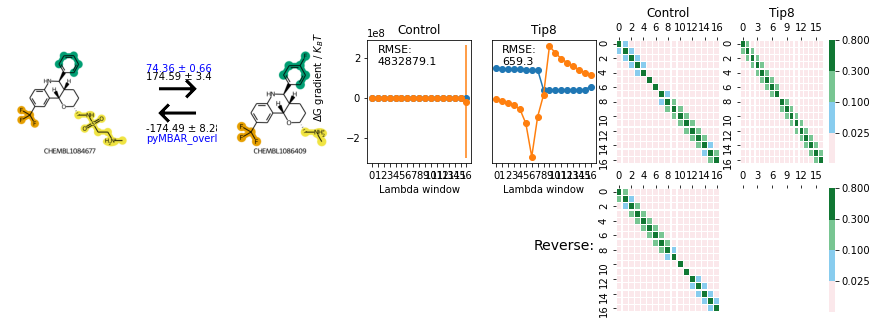

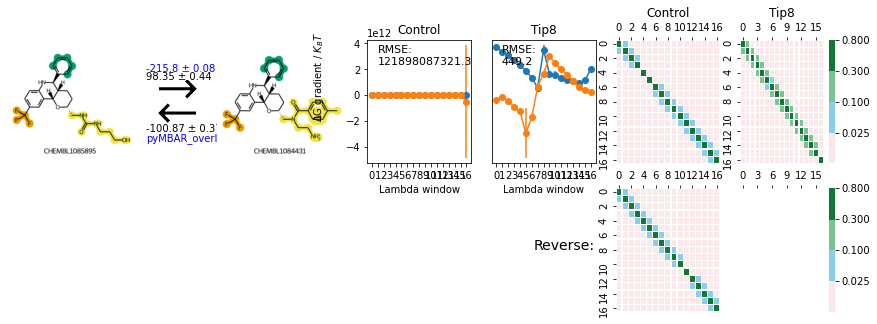

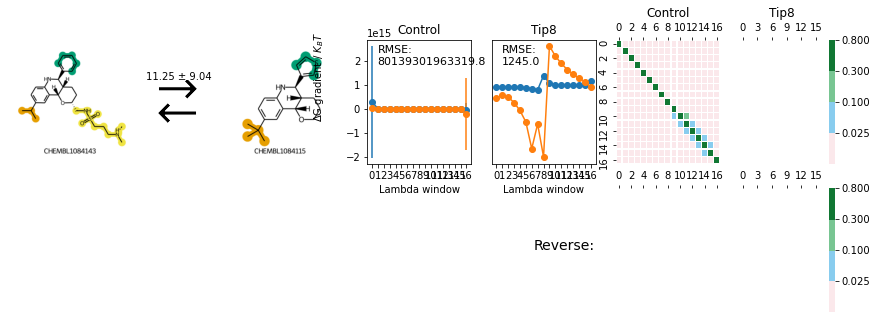

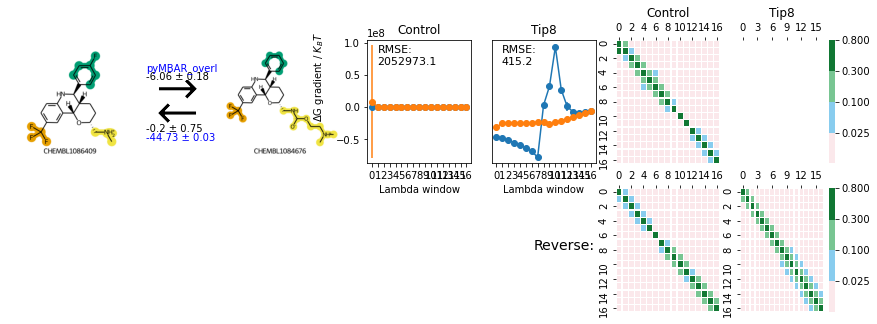

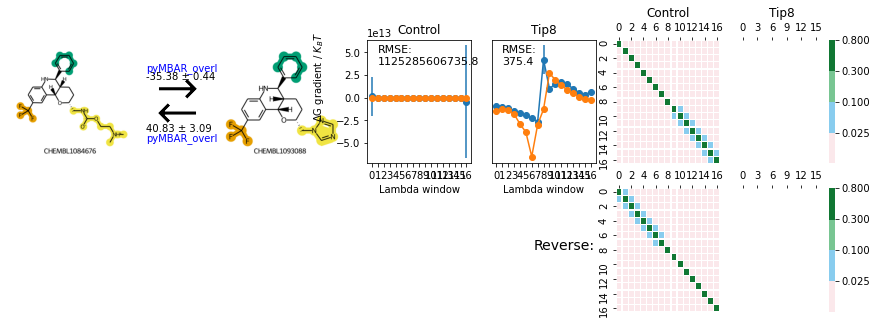

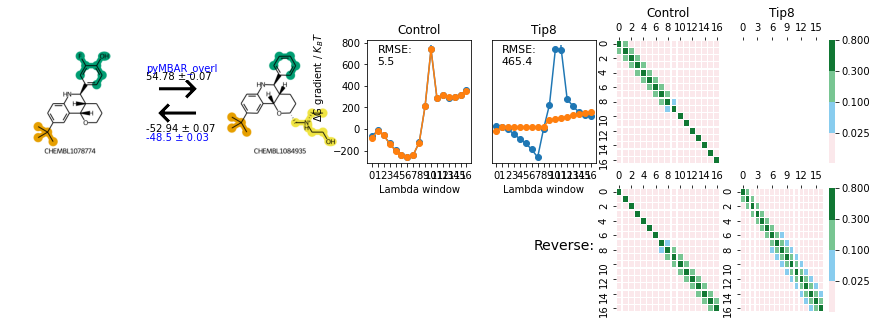

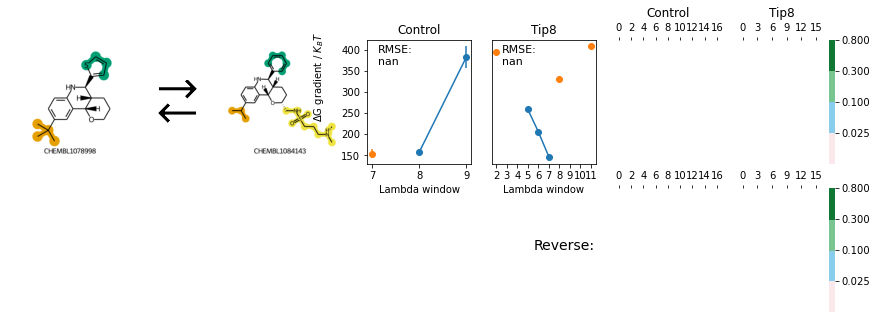

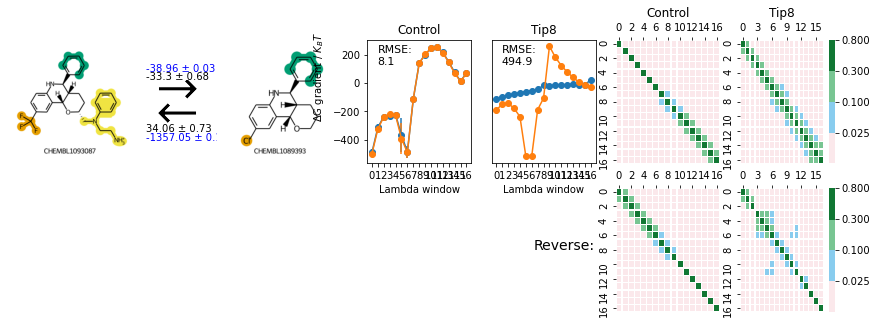

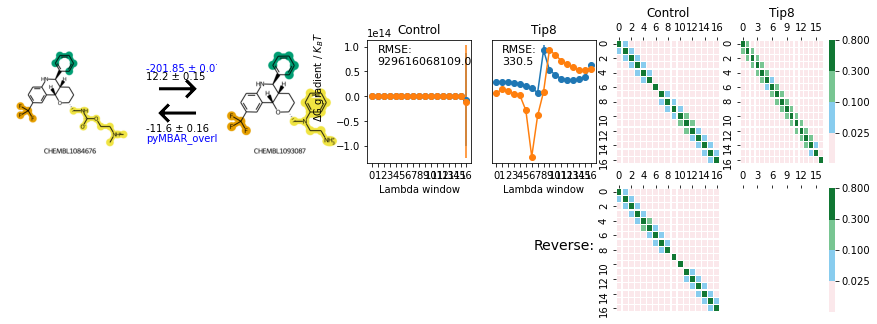

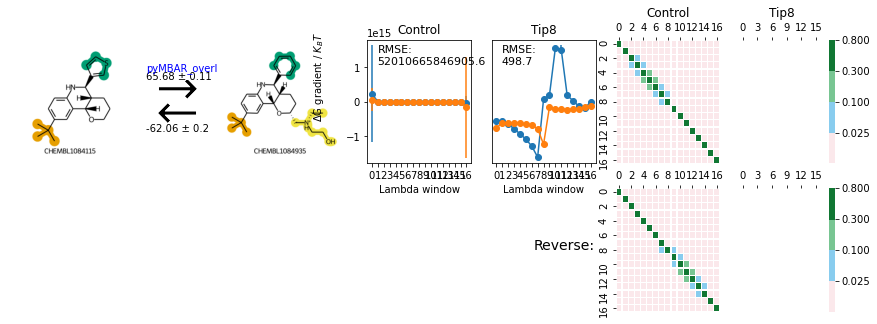

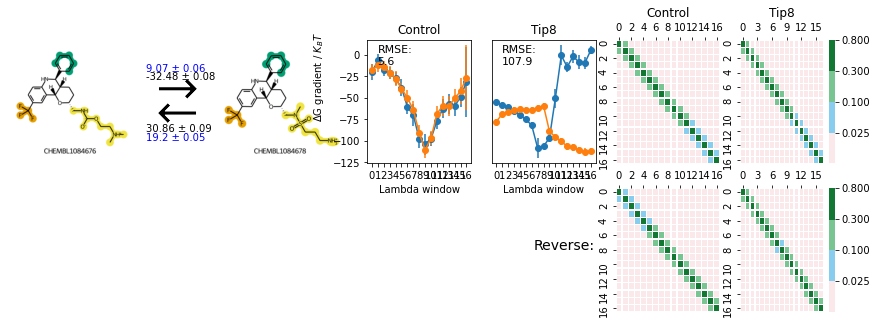

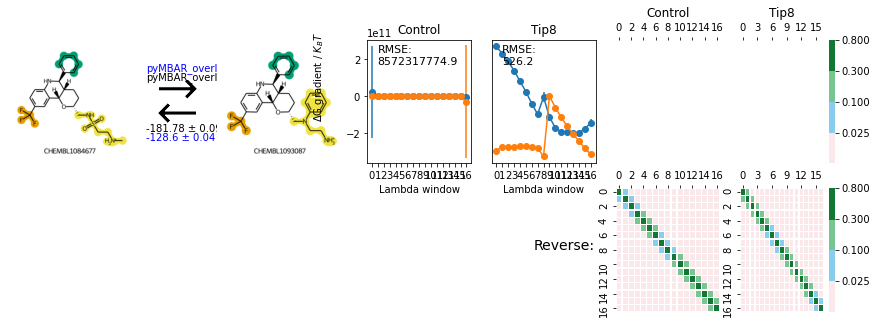

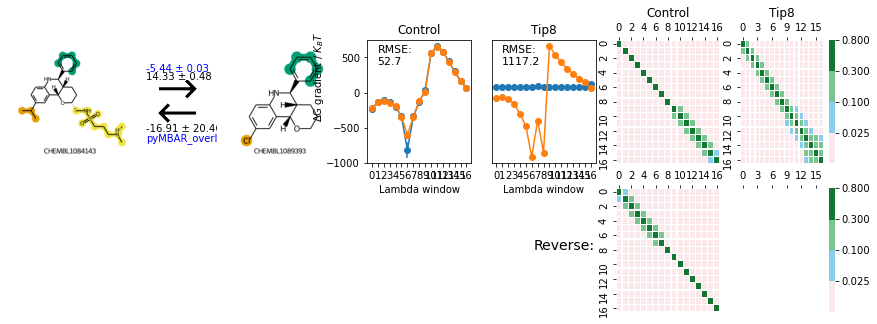

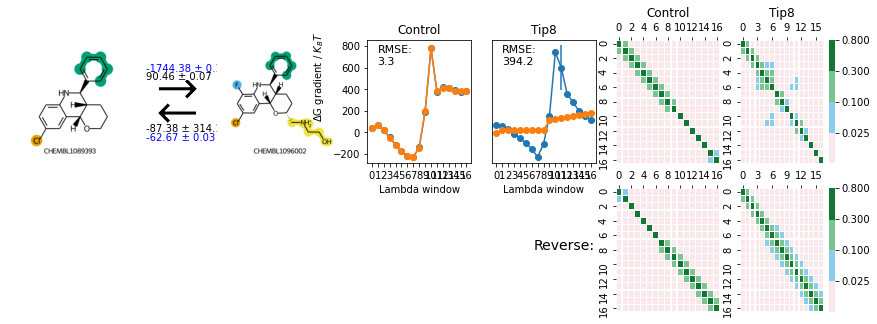

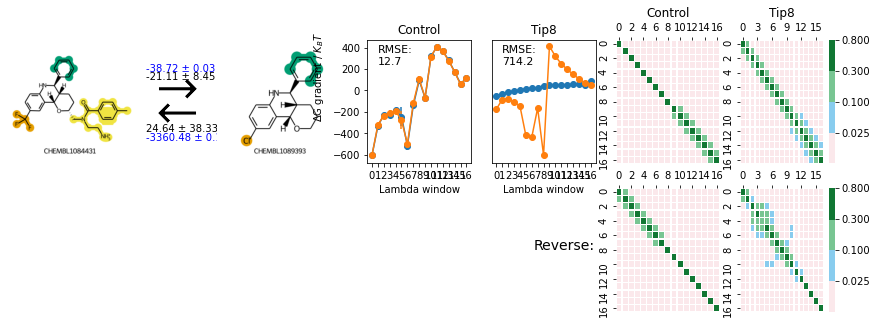

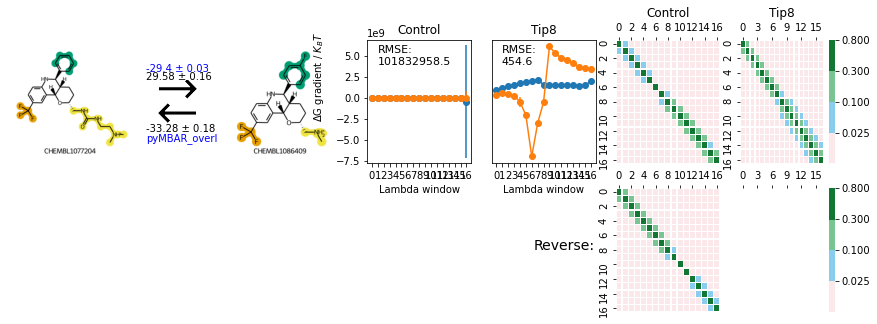

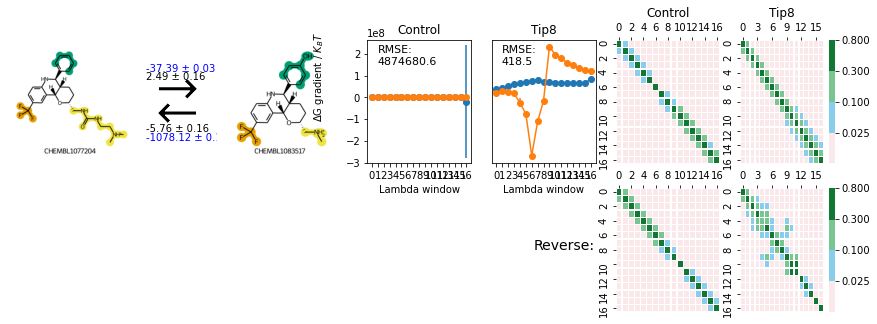

In [75]:
inv_processed = []
num_lambdas = 17
ps_overlaps = []


print("Perturbations; black=control, blue=split8")
for pert, info in mbar_dict.items():

    ligA = pert.split("~")[0]
    ligB = pert.split("~")[1]
    inv_processed.append(ligB+"~"+ligA)

    inverse_info = mbar_dict[ligB+"~"+ligA]

    if not pert in inv_processed:
        imgs_path = "../pre_setup/ligands/"

        imgA = mpimg.imread(imgs_path+ligA+".png")
        arrow = mpimg.imread(imgs_path+"arrow.png")
        imgB = mpimg.imread(imgs_path+ligB+".png")

        fig, ax = plt.subplots(2,7, figsize=(15,5),  gridspec_kw={'width_ratios': [1, 0.3, 1, 0.8, 0.8, 0.8, 0.8]})
        ax[0][0].imshow(imgA)
        ax[0][1].imshow(arrow)
        
                
        # now annotate arrows with data:
        
        # first:
        try:
            display_str = str(round(float(info[0]), 2))+" ± "+str(round(float(info[1]), 2))
        except ValueError:
            display_str = info[2]
        ax[0][1].annotate(display_str, xy=(-0.3,1), xycoords="axes fraction", size=10)
        
        # second:
        try:
            display_str = str(round(float(info[4]), 2))+" ± "+str(round(float(info[5]), 2))
        except ValueError:
            display_str = info[6]
        ax[0][1].annotate(display_str, xy=(-0.3,1.2), xycoords="axes fraction", size=10, color="blue")
        
        # repeat for inverse/reverse arrow:
        # first:
        try:
            display_str = str(round(float(inverse_info[0]), 2))+" ± "+str(round(float(inverse_info[1]), 2))
        except ValueError:
            display_str = inverse_info[2]
        ax[0][1].annotate(display_str, xy=(-0.3,-0.2), xycoords="axes fraction", size=10)
        # second:
        try:
            display_str = str(round(float(inverse_info[4]), 2))+" ± "+str(round(float(inverse_info[5]), 2))
        except ValueError:
            display_str = inverse_info[6]
        ax[0][1].annotate(display_str, xy=(-0.3,-0.4), xycoords="axes fraction", size=10, color="blue")
        
        
        
        
        
        
        # turn off axes for perturbation:
        for axis in [ax[0][0], ax[0][1], ax[0][2]]:
            axis.axis('off')
        # turn off axes for empty plots:
        for axis in [ax[1][0], ax[1][1], ax[1][2], ax[1][3], ax[1][4]]:
            axis.axis('off')
            
        ax[0][2].imshow(imgB)
        
        # plot gradients:
        perts_folder = "/Users/jscheen/projects/cresset/eg5_doa/yOUTPUTS/runs_ctl"
        perts_folder2 = "/Users/jscheen/projects/cresset/eg5_doa/yOUTPUTS/runs_tip8"
        
        plotGradients(pert, axis=ax[0][3], perts_path=perts_folder, title="Control")
        plotGradients(pert, axis=ax[0][4], perts_path=perts_folder2, title="Tip8", yax=False)
        
        
        
        
        # plot overlap matrix as in livecoms paper:
        # forward:
        plotOverlapMatrix(info[3], title="Control", ax=ax[0][5])
        plotOverlapMatrix(info[7], title="Tip8", ax=ax[0][6], colourbar=True)
        
        # reverse:
        plotOverlapMatrix(inverse_info[3], title="", ax=ax[1][5])
        plotOverlapMatrix(inverse_info[7], title="", ax=ax[1][6], colourbar=True)  
        
        ax[1][4].annotate("Reverse:", xy=(0.4,0.5), xycoords="axes fraction", size=14)
        
        # take the off-diagonal values and add to df if there is info:
        ovlp_mtx = np.matrix(info[3])
        ovlp_mtx = np.reshape(ovlp_mtx, (-1, num_lambdas))
        off_diagonal_vals = np.diagonal(ovlp_mtx, offset=1)
        
        if len(off_diagonal_vals) == (len(ovlp_mtx)-1):
            ps_overlaps.append([off_diagonal_vals, "Control"])
        else:
            # if there isn't an overlap matrix, just append zeroes:
            # below histograms should have decreasing spike at 0 when protocol improves.
            ps_overlaps.append([[0]*(num_lambdas-1), "Control"])
                
                
        # repeat for second set:
        ovlp_mtx = np.matrix(info[7])
        ovlp_mtx = np.reshape(ovlp_mtx, (-1, num_lambdas))
        off_diagonal_vals = np.diagonal(ovlp_mtx, offset=1)
        if len(off_diagonal_vals) == (len(ovlp_mtx)-1):
            ps_overlaps.append([off_diagonal_vals, "Tip8 - whole body"])
        else:
            ps_overlaps.append([[0]*(num_lambdas-1), "Tip8 - whole body"])

        
        # finally, plot this pert's info:        
        plt.show()

## Plot distributions:

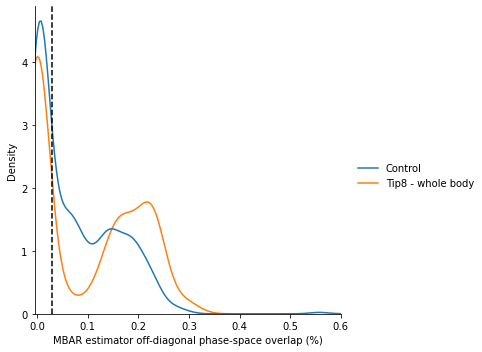

In [133]:
overlaps_df = pd.DataFrame(ps_overlaps, columns=["overlaps", "Type"])

# get rid of column formatting (needed in case we revert back to stacked barplots):
overlaps_df = overlaps_df.explode("overlaps")
overlaps_df["overlaps"] = overlaps_df["overlaps"].astype(float)

# plot kernel density estimate:
dplot = sns.displot(overlaps_df, x="overlaps", hue="Type", kind="kde", bw_adjust=0.8)
plt.axvline(0.03, ls="--", color="black")
plt.xlim(-0.005, 0.6)
plt.xlabel("MBAR estimator off-diagonal phase-space overlap (%)")
dplot._legend.set_title("")

plt.show()


- Control behaves better than tip8
- Where tip8 actually produces MBAR results: 

    <span style="color:green">Overlap is much better</span>
    
    <span style="color:red">Poor gradient overlap</span>
    
    <span style="color:red">Strong hysteresis</span>
    
There seems to be an issue with reversibility with tip8. Perhaps there is should be a difference in split when growing or shrinking? --> Looks like shrinking works fine with tip8, but growing doesn't like it.

Todo:

start with plotting bidirectional overlap matrices (subplots(2,7)).

- Look into why so many MBARs failed for tip8 compared to control. Patterns?

Looks like these are growing perts mostly.


- Look into why tip8 seems to benefit large shrinks, but not small shrinks. 

Should just do reverse transformations for growing perts? Makes sense in terms of water displacement -> growth first push waters away, then coulomb.


- Some matrices we would expect to start working with split8, e.g. 1096003 1089393

Fixed these; pymbar seems to print some verbose statements in some cases messing up the python script that reads MBAR.dat. Now they are read correctly (instead of line.startswith("#MBAR"), now <if "#MBAR Overlap" in line>)

- Any patterns with >1 group perturbations?

Not observable -> would make sense to do per-atom split instead of per-molecule, seeing as different r-groups might be shrinking/growing.

- Select 10 perturbations to run next few production runs with (i.e. 2*10). Exclude ring jumps bc out of scope?


- for next runs, align Sire version and somd.cfg!

- for next analyses, overlay density plots of off-diagonal distributions. See shift to right-hand?

In [ ]:
# backup in case we decide to look at perturbation distributions:
# fig, axes = plt.subplots(1, 2,)
# axes[0].hist(ps_overlaps_1.values,80, stacked=True)
# axes[0].set_title("Control")

# axes[1].hist(ps_overlaps_2.values,40, stacked=True)
# axes[1].set_title("Tip8")

# axes[0].set_xlabel("MBAR Phase-space off-diagonal overlap")
# axes[1].set_xlabel("MBAR Phase-space off-diagonal overlap")

# axes[0].set_ylabel("Count")

# axes[0].set_xlim(0, 0.4)

# axes[0].axvline(0.03, ls="--", color="black")
# axes[1].axvline(0.03, ls="--", color="black")

# plt.tight_layout()
# plt.show()

## Check first bound result @ 4ns/17w:

In [10]:
# read in dict with mbar outputs:
mbar_dict = {}
with open("../yOUTPUTs/CHEMBL1084676~CHEMBL1089393/mbar_outputs.csv", "r") as readfile:
    reader = csv.reader(readfile)
    for row in reader:
        mbar_dict[row[0]] = row[1:]

In [12]:
def plotOverlapMatrix(info, ax, title, colourbar=False):
    ovlp_mtx = np.matrix(info)
    ovlp_mtx = np.reshape(ovlp_mtx, (-1, num_lambdas))


    cmap = colors.ListedColormap(['#FBE8EB','#88CCEE','#78C592', '#117733'])
    bounds=[0.0, 0.025, 0.1, 0.3,0.8]
    norm = colors.BoundaryNorm(bounds, cmap.N, clip=False)
    cbar_kws=dict(ticks=[.025, .1, .3,0.8])
    if colourbar:
        ax = sns.heatmap(ovlp_mtx,annot=False, fmt='.2f', linewidths=.3, 
                    annot_kws={"size": 12},square=False,robust=True,cmap=cmap, 
                    norm=norm,cbar_kws=cbar_kws, ax=ax)
    elif not colourbar:
        ax = sns.heatmap(ovlp_mtx,annot=False, fmt='.2f', linewidths=.3,cmap=cmap, 
                    annot_kws={"size": 12},square=False,robust=True, 
                    norm=norm, ax=ax, cbar=False)
    ax.set_title(title)
    ax.xaxis.tick_top()

dict_keys(['1_discharge_soft', '2_vanish_soft', '5_grow_soft', '4_change_hard', '3_change_bonds', 'vanilla', '6_charge_soft'])


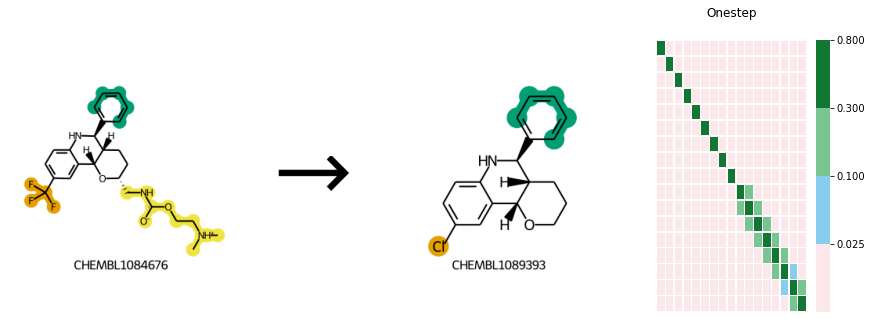

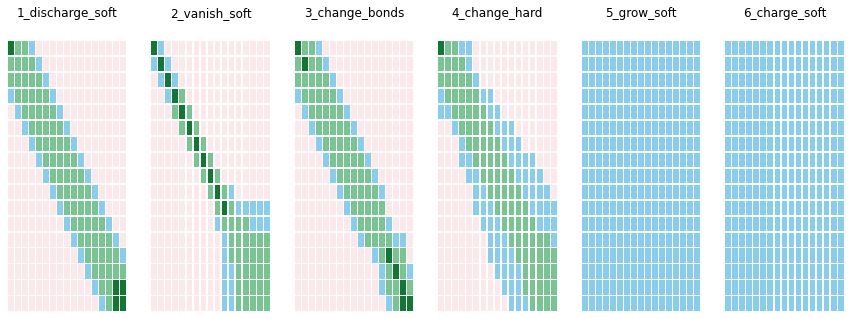

In [26]:
inv_processed = []
num_lambdas = 17
ps_overlaps = []

ligA = "CHEMBL1084676"
ligB = "CHEMBL1089393"

imgs_path = "../pre_setup/ligands/"

imgA = mpimg.imread(imgs_path+ligA+".png")
arrow = mpimg.imread(imgs_path+"arrow.png")
imgB = mpimg.imread(imgs_path+ligB+".png")

fig, ax = plt.subplots(1,4, figsize=(15,5),  gridspec_kw={'width_ratios': [1, 0.3, 1, 0.8]})
ax[0].imshow(imgA)
ax[1].imshow(arrow)

# turn off axes for perturbation:
for axis in ax:
    axis.axis('off')

ax[2].imshow(imgB)

#################################


# plot overlap matrix as in livecoms paper:
plotOverlapMatrix(mbar_dict["vanilla"][3], title="Onestep", ax=ax[3], colourbar=True)

fig2, ax2 = plt.subplots(1,6, figsize=(15,5))
plotOverlapMatrix(mbar_dict["1_discharge_soft"][3], title="1_discharge_soft", ax=ax2[0])
plotOverlapMatrix(mbar_dict["2_vanish_soft"][3], title="2_vanish_soft", ax=ax2[1])
plotOverlapMatrix(mbar_dict["3_change_bonds"][3], title="3_change_bonds", ax=ax2[2])
plotOverlapMatrix(mbar_dict["4_change_hard"][3], title="4_change_hard", ax=ax2[3])
plotOverlapMatrix(mbar_dict["5_grow_soft"][3], title="5_grow_soft", ax=ax2[4])
plotOverlapMatrix(mbar_dict["6_charge_soft"][3], title="6_charge_soft", ax=ax2[5])
# turn off axes for perturbation:
for axis in ax2:
    axis.axis('off')

# finally, plot this pert's info:        
plt.show()

Looks good, hopefully the reverse perturbation shows the same. A logical approach would be to merge 3/4, and to drop either 1/2 or 5/6 by deciding whether the perturbation involves growing or shrinking atoms (both at the same time should be discouraged for large perts). In that threestep approach, the growing/shrinking step should be allocated the majority of lambda windows. 

In [13]:
# read in dict with mbar outputs:
mbar_dict = {}
with open("../yOUTPUTs/CHEMBL1089393~CHEMBL1084676_12/mbar_outputs_17w_ctl.csv", "r") as readfile:
    reader = csv.reader(readfile)
    for row in reader:
        mbar_dict[row[0].replace("/","")] = row[1:]

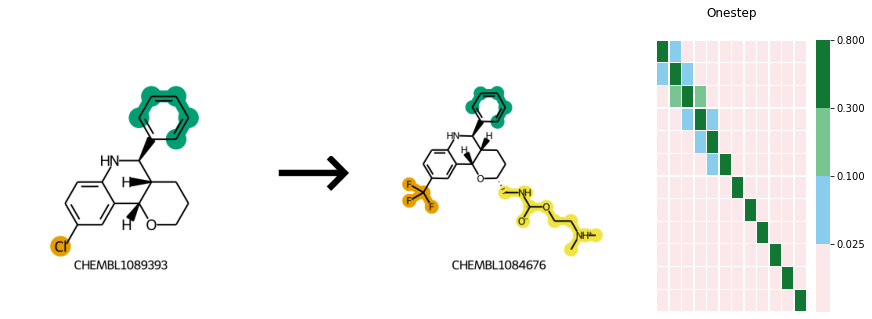

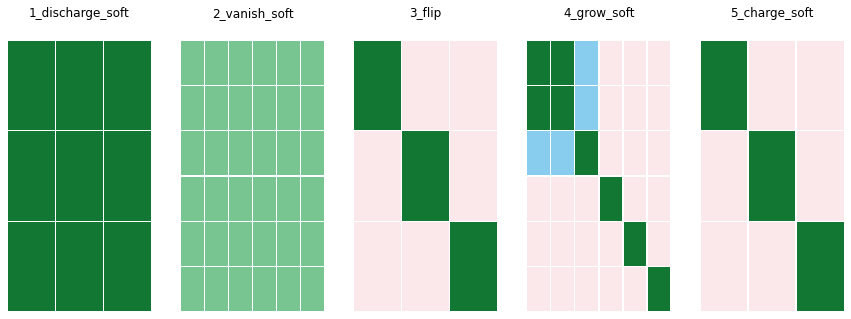

In [23]:
inv_processed = []
num_lambdas = 3
ps_overlaps = []

ligA = "CHEMBL1089393"
ligB = "CHEMBL1084676"

imgs_path = "../pre_setup/ligands/"

imgA = mpimg.imread(imgs_path+ligA+".png")
arrow = mpimg.imread(imgs_path+"arrow.png")
imgB = mpimg.imread(imgs_path+ligB+".png")

fig, ax = plt.subplots(1,4, figsize=(15,5),  gridspec_kw={'width_ratios': [1, 0.3, 1, 0.8]})
ax[0].imshow(imgA)
ax[1].imshow(arrow)

# turn off axes for perturbation:
for axis in ax:
    axis.axis('off')

ax[2].imshow(imgB)

#################################


# plot overlap matrix as in livecoms paper:
num_lambdas = 12
plotOverlapMatrix(mbar_dict["vanilla"][3], title="Onestep", ax=ax[3], colourbar=True)

fig2, ax2 = plt.subplots(1,5, figsize=(15,5))
num_lambdas = 3
plotOverlapMatrix(mbar_dict["1_discharge_soft"][3], title="1_discharge_soft", ax=ax2[0])
num_lambdas = 6
plotOverlapMatrix(mbar_dict["2_vanish_soft"][3], title="2_vanish_soft", ax=ax2[1])
num_lambdas = 3
plotOverlapMatrix(mbar_dict["3_flip"][3], title="3_flip", ax=ax2[2])
num_lambdas = 6
plotOverlapMatrix(mbar_dict["4_grow_soft"][3], title="4_grow_soft", ax=ax2[3])
num_lambdas = 3
plotOverlapMatrix(mbar_dict["5_charge_soft"][3], title="5_charge_soft", ax=ax2[4])
# turn off axes for perturbation:
for axis in ax2:
    axis.axis('off')

# finally, plot this pert's info:        
plt.show()

Now try some more lambdas:

In [4]:
# read in dict with mbar outputs:
mbar_dict = {}
with open("../yOUTPUTs/CHEMBL1084935~CHEMBL1086410_21/mbar_outputs_17w_ctl.csv", "r") as readfile:
    reader = csv.reader(readfile)
    for row in reader:
        mbar_dict[row[0].replace("/","")] = row[1:]

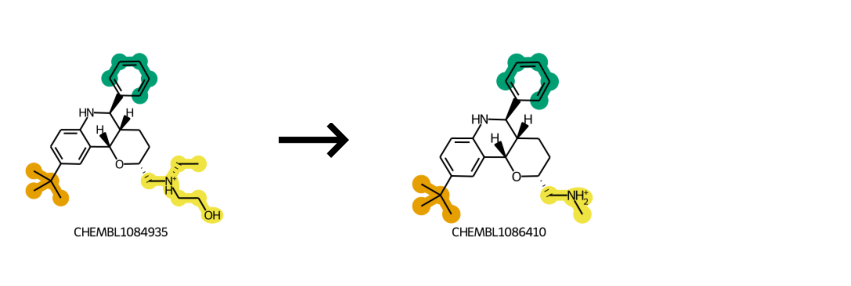

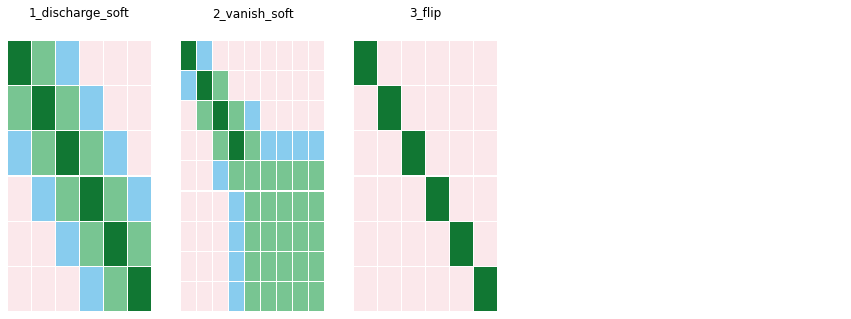

In [6]:
inv_processed = []
ps_overlaps = []

ligA = "CHEMBL1084935"
ligB = "CHEMBL1086410"

imgs_path = "../pre_setup/ligands/"

imgA = mpimg.imread(imgs_path+ligA+".png")
arrow = mpimg.imread(imgs_path+"arrow.png")
imgB = mpimg.imread(imgs_path+ligB+".png")

fig, ax = plt.subplots(1,4, figsize=(15,5),  gridspec_kw={'width_ratios': [1, 0.3, 1, 0.8]})
ax[0].imshow(imgA)
ax[1].imshow(arrow)

# turn off axes for perturbation:
for axis in ax:
    axis.axis('off')

ax[2].imshow(imgB)

#################################


# plot overlap matrix as in livecoms paper:
# num_lambdas = 12
# plotOverlapMatrix(mbar_dict["vanilla"][3], title="Onestep", ax=ax[3], colourbar=True)

fig2, ax2 = plt.subplots(1,5, figsize=(15,5))
num_lambdas = 6
plotOverlapMatrix(mbar_dict["1_discharge_soft"][3], title="1_discharge_soft", ax=ax2[0])
num_lambdas = 9
plotOverlapMatrix(mbar_dict["2_vanish_soft"][3], title="2_vanish_soft", ax=ax2[1])
num_lambdas = 6
plotOverlapMatrix(mbar_dict["3_flip"][3], title="3_flip", ax=ax2[2])

# turn off axes for perturbation:
for axis in ax2:
    axis.axis('off')

# finally, plot this pert's info:        
plt.show()

vanilla didn't run for some reason, will look into this.. Interesting observation here is that 3_flip needs more lambdas whereas the other two steps seem fine. Perhaps this has to do with the fact that this pert is relatively small?

results with even more lambda allocs per step:

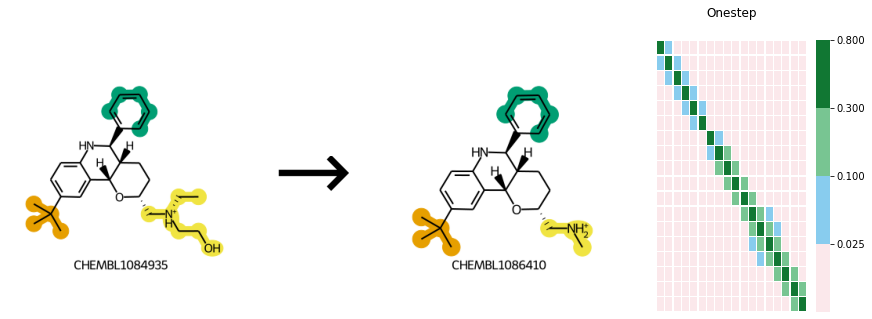

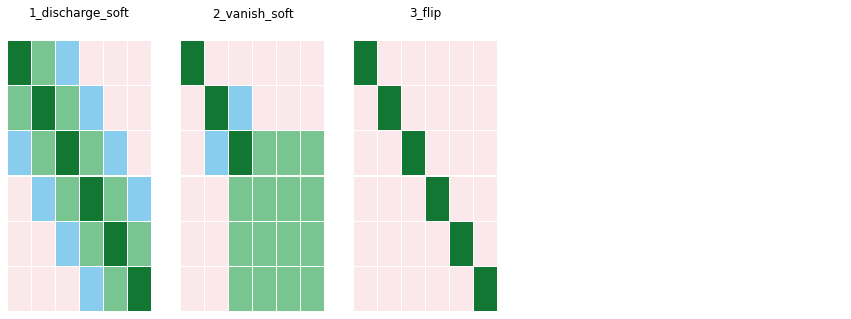

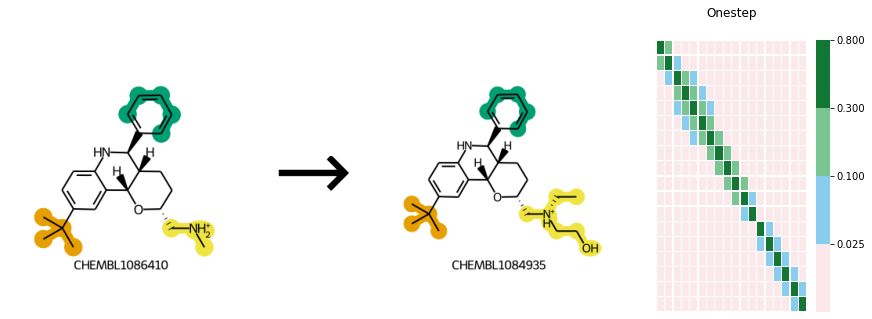

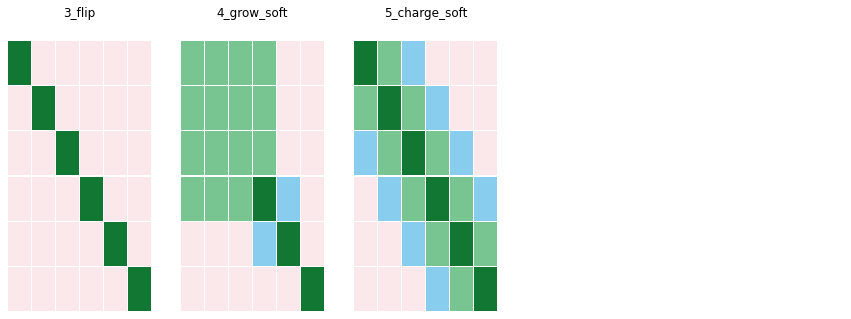

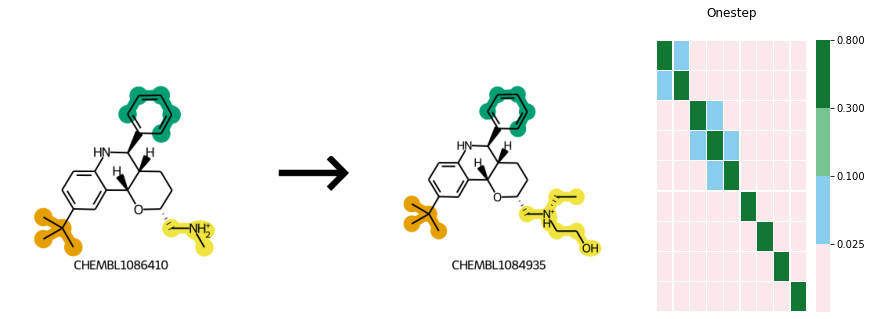

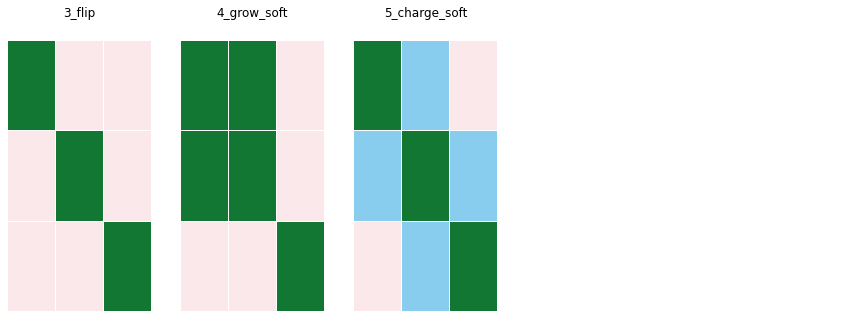

/Users/jscheen/anaconda2/envs/cresset/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/jscheen/anaconda2/envs/cresset/lib/python3.7/site-packages/seaborn/matrix.py:311: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


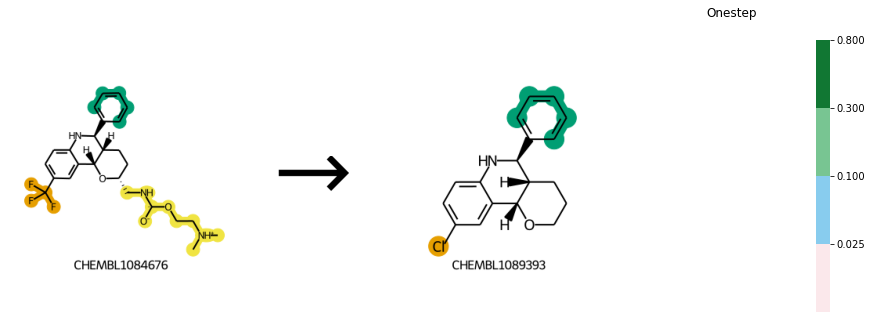

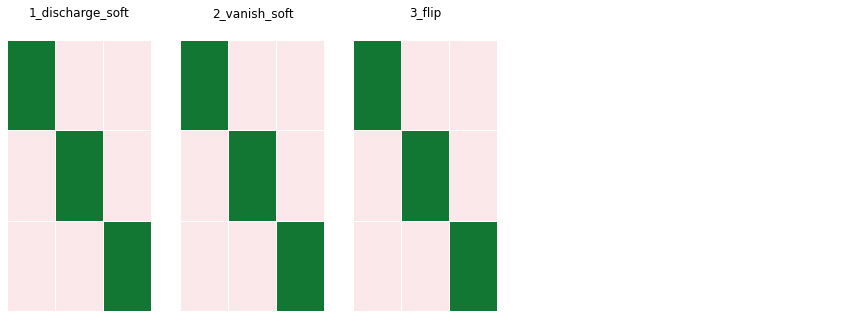

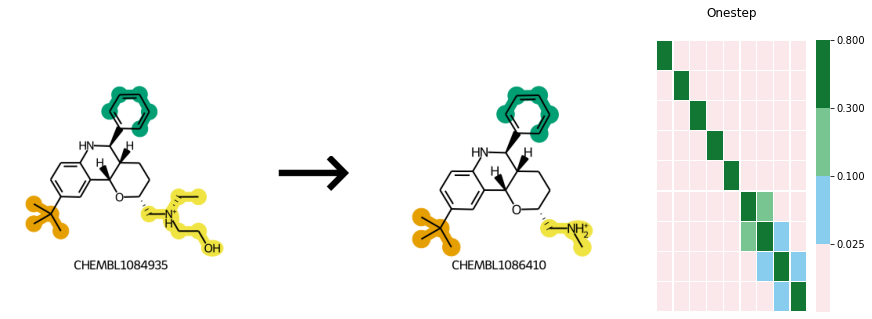

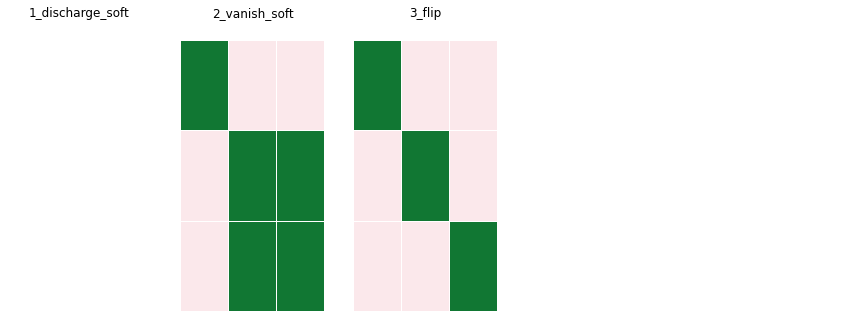

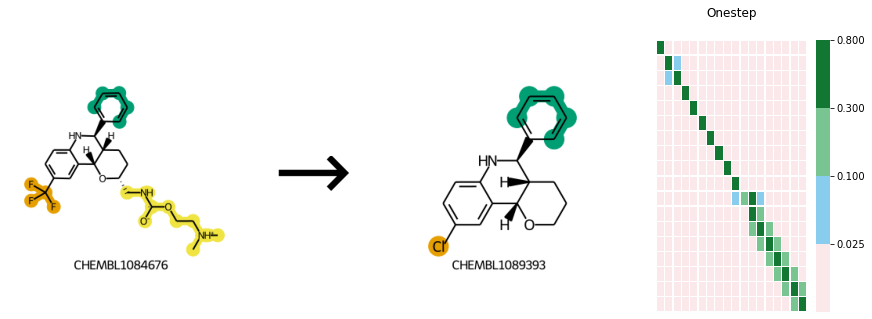

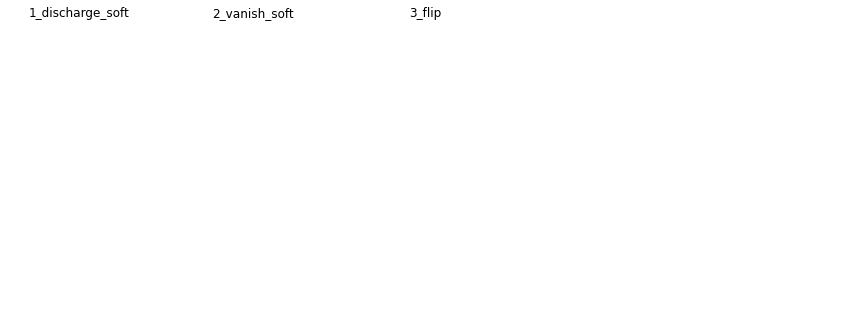

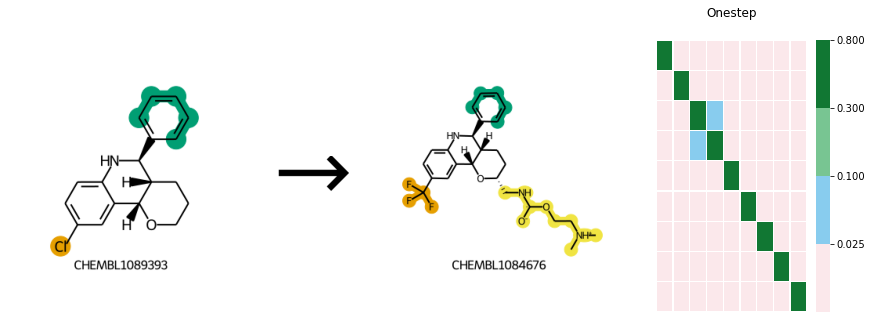

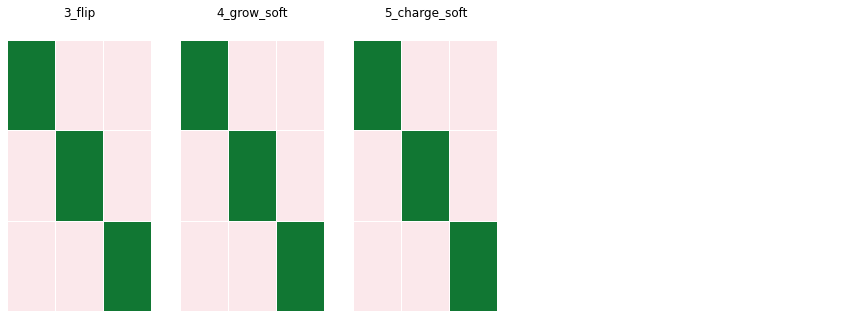

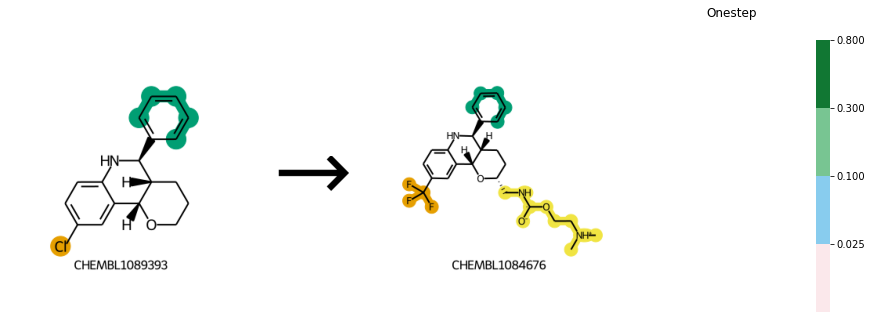

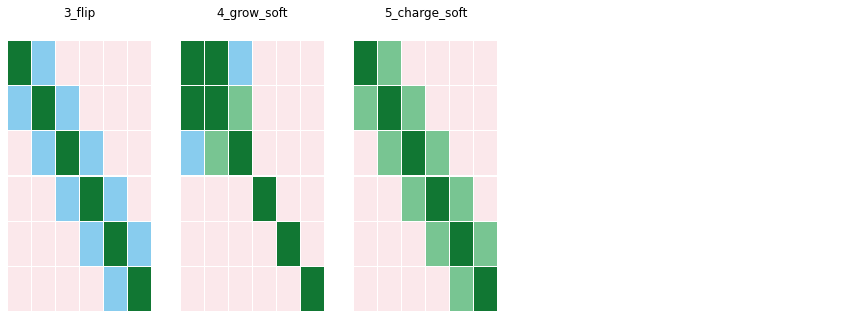

In [21]:


tried_perts = glob.glob("../yOUTPUTS/8_3step_bound_large/CHEM*")
for pert in tried_perts:
    
    # read in dicts with mbar outputs:
    mbar_dict = {}
    ligA = pert.split("/")[3].split("_")[0].split("~")[0]

    ligB = pert.split("/")[3].split("_")[0].split("~")[1]
    num_windows_vanilla = int(pert.split("/")[3].split("_")[1])
    
    with open(pert+"/mbar_outputs_17w_ctl.csv", "r") as readfile:
        reader = csv.reader(readfile)
        for row in reader:
            mbar_dict[row[0].replace("/","")] = row[1:]
        imgs_path = "../pre_setup/ligands/"

    imgA = mpimg.imread(imgs_path+ligA+".png")
    arrow = mpimg.imread(imgs_path+"arrow.png")
    imgB = mpimg.imread(imgs_path+ligB+".png")

    fig, ax = plt.subplots(1,4, figsize=(15,5),  gridspec_kw={'width_ratios': [1, 0.3, 1, 0.8]})
    ax[0].imshow(imgA)
    ax[1].imshow(arrow)

    # turn off axes for perturbation:
    for axis in ax:
        axis.axis('off')

    ax[2].imshow(imgB)

    #################################


    # plot overlap matrix as in livecoms paper:
    num_lambdas = num_windows_vanilla
    plotOverlapMatrix(mbar_dict["vanilla"][3], title="Onestep", ax=ax[3], colourbar=True)

    fig2, ax2 = plt.subplots(1,5, figsize=(15,5))
    if "1_discharge_soft" in mbar_dict:

        if num_windows_vanilla == 9:
            num_lambdas = 3
        elif num_windows_vanilla == 18:
            num_lambdas = 6
        plotOverlapMatrix(mbar_dict["1_discharge_soft"][3], title="1_discharge_soft", ax=ax2[0])
        
        if num_windows_vanilla == 9:
            num_lambdas = 3
        elif num_windows_vanilla == 18:
            num_lambdas = 6
        plotOverlapMatrix(mbar_dict["2_vanish_soft"][3], title="2_vanish_soft", ax=ax2[1])
        
        if num_windows_vanilla == 9:
            num_lambdas = 3
        elif num_windows_vanilla == 18:
            num_lambdas = 6
        plotOverlapMatrix(mbar_dict["3_flip"][3], title="3_flip", ax=ax2[2])

    else:
        if num_windows_vanilla == 9:
            num_lambdas = 3
        elif num_windows_vanilla == 18:
            num_lambdas = 6
        plotOverlapMatrix(mbar_dict["3_flip"][3], title="3_flip", ax=ax2[0])
        
        if num_windows_vanilla == 9:
            num_lambdas = 3
        elif num_windows_vanilla == 18:
            num_lambdas = 6
        plotOverlapMatrix(mbar_dict["4_grow_soft"][3], title="4_grow_soft", ax=ax2[1])
        
        if num_windows_vanilla == 9:
            num_lambdas = 3
        elif num_windows_vanilla == 18:
            num_lambdas = 6
        plotOverlapMatrix(mbar_dict["5_charge_soft"][3], title="5_charge_soft", ax=ax2[2])

    # turn off axes for perturbation:
    for axis in ax2:
        axis.axis('off')

    # finally, plot this pert's info:        
    plt.show()